# Solution of Exercise 4 (part 2): Working with binary files

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Problem 4: Parsing a binary file 

This homework will review and combine multiple concepts:
- file handling with focus on a binary file
- data types: conversion between types, and manipulation of data
- `numpy.array` data type: creation, manipulation, and slicing
- `matplotlib` extension for showing images

**Given**: 
- a binary file named `612A8347.ppm` (_download from the class website_)
- jpg file named `612A8347.jpg` to show you how the final result should look like (_for validation only_)
- a description of the binary file (given after the task list)

**Your tasks**: 
1. read this file making sure to implement at least some suitable exception handling.
   Break up the task in 
   1. reading and analyzing the general information 
   1. identifying the correct data type and format string from that information
   1. reading image information into a three-dimensional `numpy.array` named `data`.  
      `data` is organized as a 2-d array of RGB pixels, i.e., each `data[i,j,:]` is an `array([R,G,B])` for R (red), G (green), and B (blue) color values, all in the range $0\le R,G,B \le 1$.
2. Using `matplotlib.pyplot.imshow(...)`, plot the image contained in your data.
3. Create and plot three RGB-images, each containing only one or the three color channels, and plot them side by side.
4. For each of the color channels, create and plot a histogram with 256 equally sized bins (check out `numpy` and `matplotlib` for ways to generate and visualize histograms).
5. Break the original RBG image into 3x3 = 9 equal images and plot those.  Use python's `slicing` (see both `lists` and `numpy.array` documentations for that).

### locate your image.  Mine is placed inside a folder named `images` inside the `jupyter-notebooks` folder.

In [2]:
%ls

01.1 Exercise_Functions.ipynb
01.2 Solution of Exercise_Functions.ipynb
02.1 Exercise numpy.ipynb
02.2 Solution of Exercise numpy.ipynb
02.3 Exercise on more matrix operations.ipynb
02.4 Solution for Exercise on more matrix operations.ipynb
03.1 Exercise Plotting.ipynb
03.2 Solution of Exercise Plotting.ipynb
04.1 Exercise File handling.ipynb
04.2 Solution of Exercise File handling.ipynb
04.3 Exercise Handling a binary file.ipynb
04.4 Solution of Exercise Handling a binary file.ipynb
05.1 Exercise Classes.ipynb
05.2 Solution of Exercise Classes.ipynb
06.1 Exercise Modules.ipynb
06.2 Solution of Exercise Modules.ipynb
Assignment 5 Inheritance.ipynb
Human.py
Individual.py
SOLUTION for Assignment 5 Inheritance.ipynb
__pycache__/
images/


In [3]:
%ls images

612A8347.jpg  612A8347.ppm  612A8347.tif


### This example code explores the file byte by byte and reads and displays the first 24 characters.

This should help you get started with reading the header information

In [4]:
# You may need to change the filename if you are storing the image in a different location
source_filename = 'images/612A8347.ppm'

try:
    f=open(source_filename,'rb')
except IOError:
    print(f'CANNOT OPEN {source_filename} FOR READING')
    raise
    
for i in range(24):
    c = f.read(1)
    print("c[{}]: {}".format(i,c))

f.close()

c[0]: b'P'
c[1]: b'6'
c[2]: b'\n'
c[3]: b'3'
c[4]: b'1'
c[5]: b'6'
c[6]: b'2'
c[7]: b' '
c[8]: b'2'
c[9]: b'1'
c[10]: b'0'
c[11]: b'8'
c[12]: b'\n'
c[13]: b'6'
c[14]: b'5'
c[15]: b'5'
c[16]: b'3'
c[17]: b'5'
c[18]: b'\n'
c[19]: b'\xad'
c[20]: b'u'
c[21]: b'\xbc'
c[22]: b'.'
c[23]: b'\xd1'


In [5]:
# *** alternative solution for this problem ***

# You may need to change the filename if you are storing the image in a different location
source_filename = 'images/612A8347.ppm'

try:
    f=open(source_filename,'rb')
except IOError:
    print(f'CANNOT OPEN {source_filename} FOR READING')
    raise
    
header = [ f.readline(),
           f.readline(),
           f.readline() ]

for line in header:
    print(line,"-->",line.decode())

b'P6\n' --> P6

b'3162 2108\n' --> 3162 2108

b'65535\n' --> 65535



1.1 **Read the header information**

From the above initial attempt, we conclude the following:

- The binary file starts with human readable information
- There are three (3) lines of information, each ending with `'\n'`
    1. the first line contains a string, known as `magic number`.  You may google for that magic number to ID the file type.  We may ignore it for this exercise.
    2. the second line contains two numbers: width and height of the stored image in pixels.
    3. the number of colors per channel or `color depth`.  

In [6]:
import sys
from struct import unpack, calcsize
import numpy as np

source_filename = 'images/612A8347.ppm'


try:
    f=open(source_filename,'rb')
except IOError:
    print(f'CANNOT OPEN {source_filename} FOR READING')
    raise
    
    
header = ['',(0,0),0]

for i in range(3):
    line = b''
    c = unpack('c',f.read(1))[0]
    while c != b'\n':
        line += c
        c = unpack('c', f.read(1))[0]
    header[i] = line.decode()
    
magic_number = header[0]
size = [ int(x) for x in header[1].split(' ') ]
color_depth = int(header[2])

print(magic_number)
print(size)
print(color_depth)


P6
[3162, 2108]
65535


1.2. **Find dimension of the data from `color_depth`**

The third number represented color depth. 
That number is $2^{bits}-1$, with $bits$ as the  available number of bits in the data type used to represent each channel. **Note**: each byte holds 8 bits.  Common data types at `unsigned byte`, `unsigned character`, `unsigned short`, `unsigned integer`, `undigned long` or `unsigned long long`.  Use `struct.calcsize(fmt)` to identify which of the data types matches the given color depth.

In [7]:
# find bytes per color
N = 0
fmt = ''
for t in ['B','H','I','Q']:
    n_colors = 2**(calcsize(t)*8)
    print("Type '{}' offers {}".format(t,n_colors))
    if color_depth == n_colors-1:
        N = calcsize(t)
        fmt = t
        
        
print(f"---\nthe suggested format is '{fmt}' and takes {N} bytes per value")

Type 'B' offers 256
Type 'H' offers 65536
Type 'I' offers 4294967296
Type 'Q' offers 18446744073709551616
---
the suggested format is 'H' and takes 2 bytes per value


1.3. **Read the pixels into a 3-dimensional `numpy.array` named `data`**

Now that you know the correct data type for the binary storage scheme, read the data as follows:
- each pixel is represented by three consecutive numbers of the identified data type.  These numbers, in sequence, represent R, G, and B values.  Those values are $0\le R,G,B\le color~depth$ and nned to be converted to `np.array([r,g,b])` with $0\le r,g,b\le 1$.
- pixels are stored in the file sequentially forming row after row of your image.  You should know the size from the header data.
- make sure the colleacted data is a `numpy.array`!
- **Hint**: depending on your operation system, the data may appear in a native or non-native format.  You may need to specify whether your binary data is to be interpreted as `little-endian` or `big-endian` (see documentation for `struct`)

In [8]:
# read the data from file
data = []

num_color_channels = 3  # RGB  ... may cause a funny image, if wrong
# num_color_channels = 4  # RGBA ... should trigger exception, if wrong

#FMT = '<'+num_color_channels*fmt  # little-endian
FMT = '>'+num_color_channels*fmt  # big-endian

# initializing memory will speed up the process
data = np.zeros((size[1],size[0],3))

try:
    for row in range(size[1]):
        for col in range(size[0]):
            binary_data = f.read(num_color_channels*N)
            data[row,col] = np.array( unpack(FMT, binary_data) )/color_depth
except:
    print("File appears to be corrupted.")
    raise
    
# we are done reading that file
f.close()

In [9]:
# check the shape of data.  The answer should be (num_rows, num_cols, 3)
data.shape

(2108, 3162, 3)

2. **Visualize the data as RGB image**

- Check out `matplotlib.pyplot.imshow(...)`.  It should be able to visualize your `data` array quickly as an image.
- **Hint**: depending on your operation system, the data may appear in a native or non-native format.  You may need to specify whether your binary data is to be interpreted as `little-endian` or `big-endian` (see documentation for `struct`).  Picking the wrong one will make the image look very weird, while picking the write one will disclose what I've done last weekend.

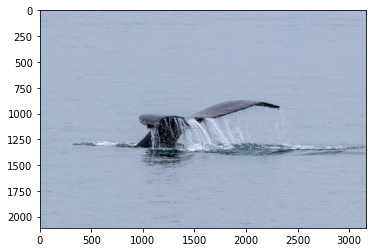

In [10]:
import matplotlib.pyplot as plt

imgplot = plt.imshow(data)

Here is a look at the top left corner.  If you plot this for your data and the first 3 pixels are some shade of black, you forgot to skip the header before reading pixel data.

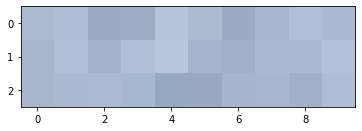

In [11]:
plt.imshow(data[:3,:10,:])

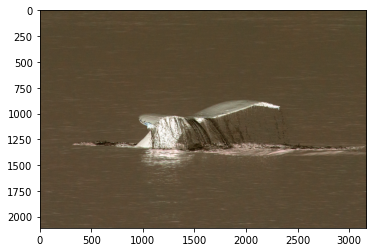

In [11]:
# just for the fun of it: here is the negative
imgplot = plt.imshow(1.-data)

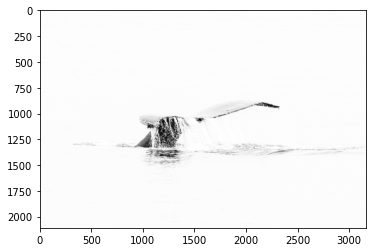

In [12]:
# A fun greyscale conversion
greyImg = (1.-data[:,:,0])*(1.-data[:,:,1])*(1-data[:,:,2])
imgplot = plt.imshow(greyImg,cmap='Greys')

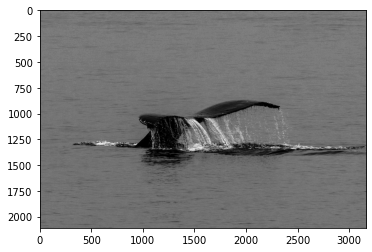

In [13]:
# A fun greyscale conversion
greyImg = 1.-(data[:,:,0])*(data[:,:,1])*(data[:,:,2])
imgplot = plt.imshow(greyImg,cmap='Greys')

3.1 **Visualize each color channel seperately**

While it may be tempting to use `data[:,:,i]` for the `i`th channel, that form represents a greyscale image of that color channel and will generate fake colors.  Make sure to create another RGB image.

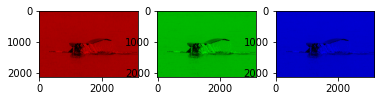

In [14]:
fig, ax = plt.subplots(1,3)
for k in range(3):
    img = np.zeros_like(data)
    img[:,:,k] = data[:,:,k]
    ax[k].imshow(img)

3.2 **Here is the original image**

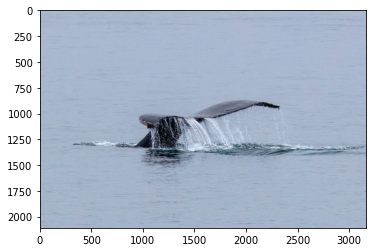

In [15]:
import matplotlib.image as mpimg

img = mpimg.imread(source_filename[:-3]+'jpg')
plt.imshow(img)

4. **Generate histograms for each color channel**

**Useful options**:
- `numpy.histogram`: https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
- `matplotlib.pyplot.hist`: https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

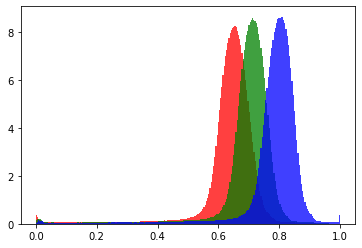

In [16]:
colors=['red','green','blue']

for k in range(3):
    channels=data[:,:,k]
    channels.shape=(size[0]*size[1])
    plt.hist(channels,bins=256,density=True,fc=colors[k],alpha=0.75)

plt.show()

5. **Viewing a zoomed image**

Think of slicing that image both vertically and horizontally into nine (9) equal images. Plot those 9 images in a 3x3 matrix (`matplotlib.pyplot.subplots`)

In [17]:
(w,h)=size

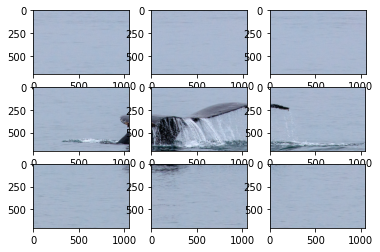

In [18]:
fig,ax = plt.subplots(3,3)

for i in range(3):
    for j in range(3):
        ax[j,i].imshow(data[(h*j//3):(h*(j+1)//3),(w*i//3):(w*(i+1)//3),:])

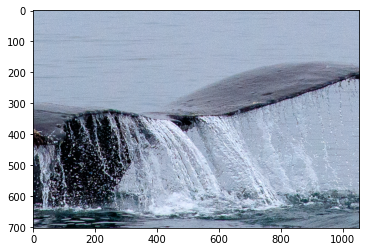

In [19]:
# just the middle image of the grid
plt.imshow(data[(h*1//3):(h*2//3),(w*1//3):(w*2//3),:])

**Pixel peeping** is a term among photographers when arguing about quality down to the individual pixel.  Let's try zooming in to various 30x30 pixel details.

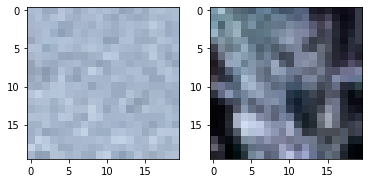

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2)
detail = data[:20,:20,:]
ax1.imshow(detail)
detail = data[1055:1075,1205:1225,:]
ax2.imshow(detail)